In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [2]:
import deepxde as dde 
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

2023-10-07 15:08:19.434115: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-07 15:08:19.434166: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-07 15:08:19.434197: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-07 15:08:19.443285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



In [3]:
rho = 1 
mu = 1 
u_in = 1
D = 1 
L = 2

In [4]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

Text(0, 0.5, 'y')

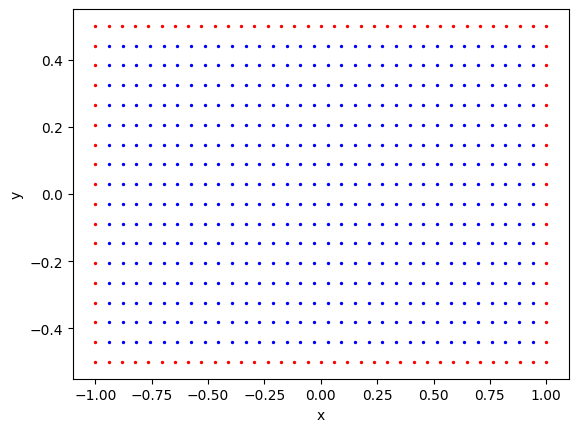

In [5]:
X = geom.uniform_points(500, boundary=False)
X_boundary = geom.uniform_boundary_points(100)
plt.scatter(X[:, 0], X[:, 1], s=2, c='b')
plt.scatter(X_boundary[:, 0], X_boundary[:, 1], s=2, c='r')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

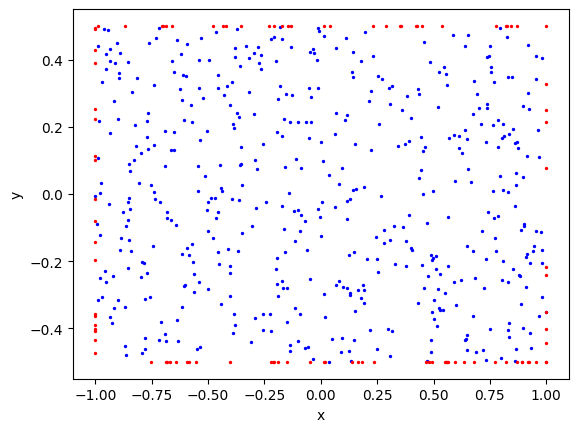

In [6]:
X = geom.random_points(500)
X_boundary = geom.random_boundary_points(100)
plt.scatter(X[:, 0], X[:, 1], s=2, c='b')
plt.scatter(X_boundary[:, 0], X_boundary[:, 1], s=2, c='r')
plt.xlabel('x')
plt.ylabel('y')

In [7]:
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
    return on_wall 

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

In [8]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
    du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
    
    dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
    dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)

    dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
    dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)

    du_xx = dde.grad.hessian(Y, X, component = 0, i = 0, j = 0)
    du_yy = dde.grad.hessian(Y, X, component = 0, i = 1, j = 1)

    dv_xx = dde.grad.hessian(Y, X, component = 1, i = 0, j = 0)
    dv_yy = dde.grad.hessian(Y, X, component = 1, i = 1, j = 1)

    u = Y[:, 0]
    v = Y[:, 1]
    p = Y[:, 2]

    pde_u = u*du_x + v*du_y + (1/rho)*dp_x - (mu/rho)*(du_xx + du_yy)
    pde_v = u*dv_x + v*dv_y + (1/rho)*dp_y - (mu/rho)*(dv_xx + dv_yy)
    pde_con = du_x + dv_y

    return [pde_u, pde_v, pde_con]

In [9]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0, boundary_wall, component=0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0, boundary_wall, component=1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component=0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0, boundary_inlet, component=1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0, boundary_outlet, component=2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0, boundary_outlet, component=1)

In [27]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v],
                    num_domain = 3000,
                    num_boundary = 500,
                    num_test = 1000,
                    train_distribution = 'LHS')

In [28]:
data.train_x_all.shape

(3500, 2)

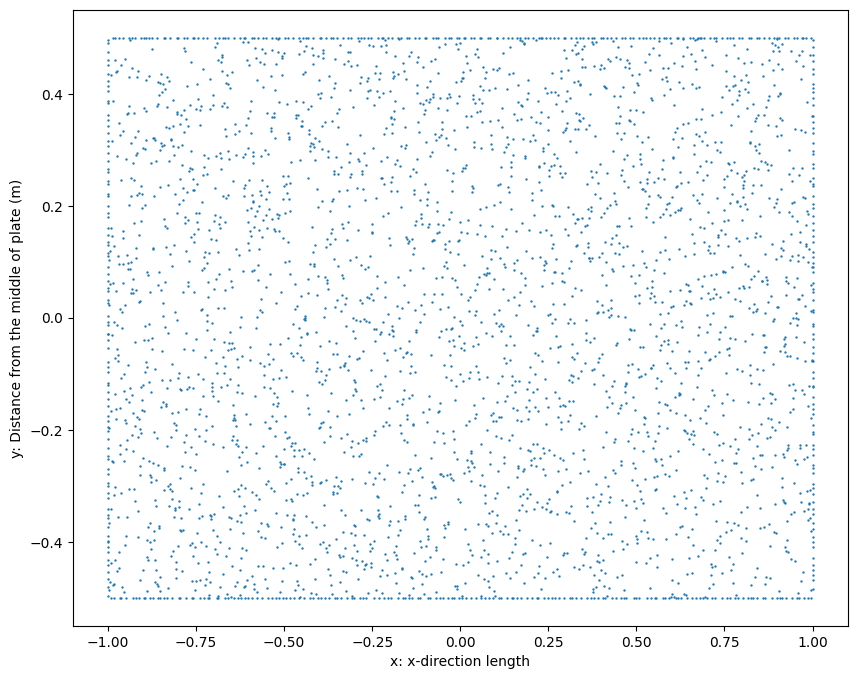

In [29]:
plt.figure(figsize=(10, 8))
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1], s = 0.5)
plt.xlabel('x: x-direction length')
plt.ylabel('y: Distance from the middle of plate (m)')
plt.show()

In [30]:
layer_size = [2] + [64] * 5 + [3]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

In [33]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.006462 s



In [34]:
samples = geom.uniform_points(500000)
result = model.predict(samples)
samples.shape, result

2023-10-07 15:11:08.217799: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:447] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2023-10-07 15:11:08.220785: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:451] Memory usage: 12126388224 bytes free, 12652838912 bytes total.
2023-10-07 15:11:08.220855: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:461] Possibly insufficient driver version: 470.182.3
2023-10-07 15:11:08.221698: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:624 : FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.


FailedPreconditionError: DNN library initialization failed. Look at the errors above for more details. [Op:__inference_outputs_491]

In [36]:
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap='jet', s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((-L/2, L/2))
    plt.ylim((-D/2, D/2))
    plt.tight_layout()
    plt.show()

NameError: name 'result' is not defined

<Figure size 2000x400 with 0 Axes>

In [37]:
losshistory, train_state = model.train(iterations = 10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

Training model...

Cause: could not parse the source code of <function <lambda> at 0x7fa80f6fb5b0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fa80f6fb5b0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fa80f6fb910>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fa

2023-10-07 15:11:17.049744: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:447] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2023-10-07 15:11:17.049863: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:451] Memory usage: 12126388224 bytes free, 12652838912 bytes total.
2023-10-07 15:11:17.049904: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:461] Possibly insufficient driver version: 470.182.3
2023-10-07 15:11:17.053322: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:624 : FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.


FailedPreconditionError: DNN library initialization failed. Look at the errors above for more details. [Op:__inference_outputs_losses_train_1113]

: 

In [ ]:
samples = geom.uniform_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap='jet', s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((-L/2, L/2))
    plt.ylim((-D/2, D/2))
    plt.tight_layout()
    plt.show()

In [ ]:
model.compile("adam", lr=1e-3)

In [ ]:
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [ ]:
samples = geom.uniform_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap='jet', s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((-L/2, L/2))
    plt.ylim((-D/2, D/2))
    plt.tight_layout()
    plt.show()

In [ ]:
model.compile("L-BFGS")

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxiter=900)

In [ ]:
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [ ]:
model.train()

In [ ]:
samples = geom.uniform_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap='jet', s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((-L/2, L/2))
    plt.ylim((-D/2, D/2))
    plt.tight_layout()
    plt.show()